# Introduction

In [79]:
import torch
from AutoDecoder import AutoDecoder
from utils import create_dataloaders, plot_tsne
from evaluate import evaluate_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

In [80]:
# Load the dataset (train and test splits are handled in the function)
train_ds, train_dl, test_ds, test_dl = create_dataloaders(data_path='dataset', batch_size=64, shuffle=True, num_workers=2)

# Debugging:
print(f"Training dataset size: {len(train_ds)}")
print(f"Test dataset size: {len(test_ds)}")
print(f"Number of batches in training DataLoader: {len(train_dl)}")
print(f"Number of batches in test DataLoader: {len(test_dl)}")

Training dataset size: 1000
Test dataset size: 1000
Number of batches in training DataLoader: 16
Number of batches in test DataLoader: 16


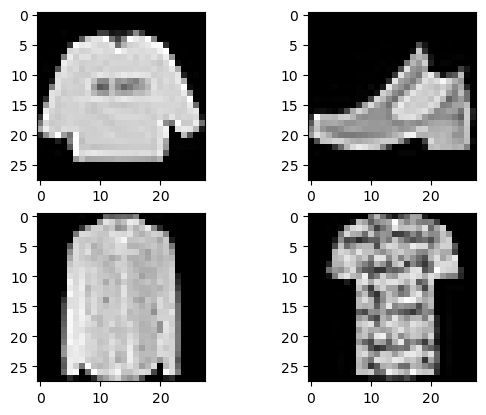

Image size: torch.Size([28, 28])


In [81]:
#explore the training dataset
plt.figure(1)
num_samples = 4
for i in range(num_samples):
    plt.subplot(221+i)
    plt.imshow(train_ds[i][1], cmap='gray')
plt.show()

#lets see the size of the images
print(f"Image size: {train_ds[0][1].shape}")

In [82]:
#lets have a look at the values of the pixels of the images
print(f"Min pixel value: {train_ds[0][1].min()}")
print(f"Max pixel value: {train_ds[0][1].max()}")

# TODO: consider if we need to normalize the images
# for i in range(len(train_ds)):
#     train_ds[i] = (train_ds[i][0], train_ds[i][1].float()/255)

Min pixel value: 0
Max pixel value: 255


# AutoDecoder

## AutoDecoder Implementation Overview

In [83]:
from AutoDecoder import Trainer
trainer = Trainer()
print(trainer.model)

AutoDecoder(
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 256, kernel_size=(7, 7), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (10): Sigmoid()
  )
)


### Architecture and Design Choices

#### 1. **Decoder Architecture**
The AutoDecoder reconstructs images from a latent space representation using a fully convolutional structure with transposed convolution layers. The reason we are using transposed convolution layers is for upsampling, and also we want to imitate "miror imaging" of the Encoder (which is not present). Moreove, the transposed convolutions are used to effectively expand spatial dimensions, which is essential for reconstructing images from compressed latent vectors. In addition we reducre the number of channels across layers. This helps refine features during each upsampling step. Also, we took inspiration for the architecture of the decoder from the following paper - arXiv:1512.09300v2 [here](https://arxiv.org/abs/1512.09300).
Below is the architecture:

- **Input**: Latent vector of size $latent\_dim$, reshaped to $(\text{batch\_size}, \text{latent\_dim}, 1, 1)$.
- **Output**: Reconstructed images of size $28\times 28$ with pixel values scaled to $[0, 255]$.

#### Layer Details:
1. **Transposed Convolution Layers**:
   - **Layer 1**: Converts the latent vector into a feature map of size $7 \times 7$ with $256$ channels.
   - **Layer 2**: Upsamples the feature map to $14 \times 14$ with $128$ channels.
   - **Layer 3**: Further upsamples to $28 \times 28$ with 64 channels.
   - **Layer 4**: Outputs the final image with 1 channel (grayscale as the inputs) using a $3 \times 3$.


2. **Activation Functions**:
   - **ReLU**: Used in intermediate layers to introduce non-linearity.
   - **Sigmoid**: Used in the output layer to normalize pixel values to $[0, 1]$. This output is multiplied by 255 in order for the values to be in the same scale as the data.


3. **Batch Normalization**:
   - Applied after each transposed convolution (except the last layer) to stabilize training and improve convergence.


4. **Upsampling**:
   - Achieved through transposed convolutions, which increase the spatial dimensions while learning meaningful patterns to fill in details. We remind that the input vector to the decoder is a vector in a smaller dimebsion so we need to "fill in" patterns in order to compare to the data.

---

### Model Parameters

1. **Kernel Size**:
   - Larger $7 \times 7$ kernel at the first layer captures broad features, while smaller kernels in later layers refine finer details.
   - We also used the following equations from the pytorch documnetation [here](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html):
   - $H_{\text{out}} = (H_{\text{in}} - 1) \times \text{stride}[0] - 2 \times \text{padding}[0] + \text{dilation}[0] \times (\text{kernel\_size}[0] - 1) + \text{output\_padding}[0] + 1 $
   - $W_{\text{out}} = (W_{\text{in}} - 1) \times \text{stride}[1] - 2 \times \text{padding}[1] + \text{dilation}[1] \times (\text{kernel\_size}[1] - 1) + \text{output\_padding}[1] + 1$



2. **Strides and Padding**:
   - Configured such that it would ensure smooth upsampling.


3. **Model Depth**:
   - Four transposed convolution layers provide sufficient capacity to reconstruct $28 \times 28$ images without overfitting. Recall we took inspiration from the above paper.


4. **Latent Dimension**:
   - We needed to choose a dimnsion that is smaller than the dimension of the data $28 \times 28 =784$. This is because the latent space represents a more compressed space of the data.
   - After experimentation where we observed the latents dimesion's effect the model's ability to generalize, we chose $latent\_dim=128$.
   - The latent dimension gives a good balance between reducing the dimensionality of the latent space for compact representation and maintaining a higher dimensional size to enable the model to capture more complex features for better reconstruction.

---

### Training Parameters

1. **Optimizer**: 
   - **Adam Optimizer**: Selected for its adaptive learning rate and momentum, ensuring stable and efficient optimization.
   - Adaptive learning rate is when the learning rate for each parameter is adjusted individually based on how frequently it has been updated. Momentum uses past gradient information to smooth out updates and avoid oscillations.


2. **Learning Rate**: 
   - Set to $0.005$, a starting value that gave stable convergence.


3. **Loss Function**:
   - **Reconstruction Loss**: Gave by the staff to use. This loss measures the discrepancy between the original and reconstructed images, ensuring the AutoDecoder prioritizes accurate image reconstruction.


4. **Batch Size**: 
   - $batch\_size=64$: Provided a balance between computational efficiency and stable gradient updates.


5. **Epochs**: 
   - Trained for 100 epochs in order to minimize reconstruction loss.


In [84]:
trainer.train_and_evaluate()

Epoch 1/100
Epoch [1/100], Loss: 0.5514
Epoch 2/100
Epoch [2/100], Loss: 0.4765
Epoch 3/100
Epoch [3/100], Loss: 0.4364
Epoch 4/100
Epoch [4/100], Loss: 0.3958
Epoch 5/100
Epoch [5/100], Loss: 0.3686
Epoch 6/100
Epoch [6/100], Loss: 0.3540
Epoch 7/100
Epoch [7/100], Loss: 0.3425
Epoch 8/100
Epoch [8/100], Loss: 0.3382
Epoch 9/100
Epoch [9/100], Loss: 0.3452
Epoch 10/100
Epoch [10/100], Loss: 0.3416
Epoch 11/100
Epoch [11/100], Loss: 0.3330
Epoch 12/100
Epoch [12/100], Loss: 0.3307
Epoch 13/100
Epoch [13/100], Loss: 0.3145
Epoch 14/100
Epoch [14/100], Loss: 0.3085
Epoch 15/100
Epoch [15/100], Loss: 0.3058
Epoch 16/100
Epoch [16/100], Loss: 0.3014
Epoch 17/100
Epoch [17/100], Loss: 0.2885
Epoch 18/100
Epoch [18/100], Loss: 0.2712
Epoch 19/100
Epoch [19/100], Loss: 0.2625
Epoch 20/100
Epoch [20/100], Loss: 0.2511
Epoch 21/100
Epoch [21/100], Loss: 0.2146
Epoch 22/100
Epoch [22/100], Loss: 0.1768
Epoch 23/100
Epoch [23/100], Loss: 0.1915
Epoch 24/100
Epoch [24/100], Loss: 0.1700
Epoch 25/1

### TSNE Plot

<p style="font-size:16px;">Plotting TSNE plot.</p>

In [85]:
trainer.plot_tsne()

Generating t-SNE plot...


<Figure size 800x600 with 0 Axes>

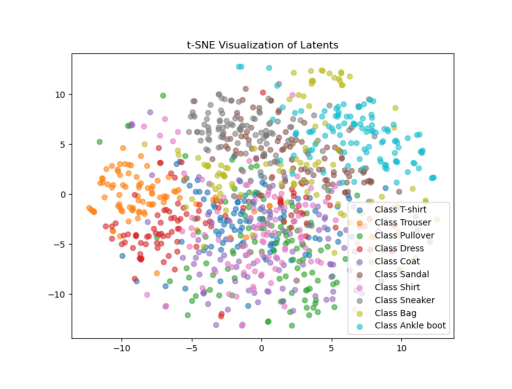

In [86]:
file_name = 'tsne_plot_AD'
image_path = f'{file_name}.png'
img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

We can see from the plot that there are som classes are organized well, but overall the classes arent seperated well. This is probably due to the fact that the model didn't learn a continuous space but rather a mapping from latent vectors to a reconstructed image similar to the data.

### Testing Samples

In [9]:
trainer.test_samples()

Generating random samples...
Saving images...
Images saved to output_images/random_latents_images.png
Saving images...
Images saved to output_images/test_set_latents_images.png


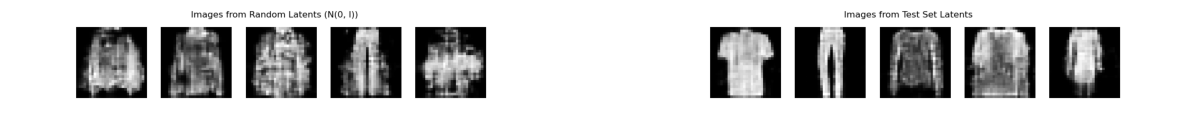

In [10]:
image_paths = ['output_images/random_latents_images.png', 'output_images/test_set_latents_images.png']

fig, axs = plt.subplots(1, len(image_paths), figsize=(15, 5))  # 1 row, len(image_paths) columns

for i, image_path in enumerate(image_paths):
    img = mpimg.imread(image_path)
    axs[i].imshow(img)
    axs[i].axis('off')  # Hide axes

plt.show()

#### Comparing Random & Test Images

##### **Results Comparission**

- We can see that the decoded test set latents gave far better results than the decoded latents from $N(0,I)$.
- The decoder learned to take a mapping of a certain image in the latent space and to construct it to an image that is close to the original one. The test latents were fitted to a close mapping in the latent space of similar images. Then the Decoder can take the test latent and reconstruct an image that is similar to the images in the data.
- On the other hand, latent vectors that were sampled randomly from $N(0,I)$ were not fitted and therefore the decoder did not learn how to construct images similiar to the data images from their mappings in the latent space.
- The decoder learned to reconstruct specific latent mappings to reconstructions closely resembling the original images. Test latents, optimized to align with the learned latent space, enabled the decoder to produce accurate reconstructions. However, randomly sampled latents do not align with the learnt latent mappings, resulting in less coherent and detailed images. This reflects the model's reliance on a latent space shaped by training (not continuous) and its limited ability to generalize to unseen latent points.

# Variational Auto Decoder - VAD

## VariationalAutoDecoder Implementation Overview

The Variational AutoDecoder is designed to reconstruct images by learning distributions in the latent space, unlike a standard AutoDecoder, which uses fixed latent vectors. This approach leverages learned distributions, making the architecture more versatile for tasks involving random sampling from the latent space.

In this design, two key parameters are initialized for each sample: the mean (μ) and standard deviation (σ) of the latent distribution. These trainable parameters enable the model to learn a unique distribution for each sample, improving generalization when generating new latents. The decoder consists of a sequence of linear layers followed by transposed convolutional layers.

The reparameterization trick was used to scale and shift Gaussian noise using the learned μ and σ for each sample. This approach ensures differentiability, enabling backpropagation through the random sampling process.

Laslty,in thhe training process an ELBO loss function was used, which combines reconstruction loss, quantifying the difference between the original and reconstructed images, and a KL divergence term that ensures the learned distribution remains close to a standard normal distribution. This balance between reconstruction accuracy and distribution regularization is essential for effective training and generalization.

In [1]:
from VariationalAutoDecoder import VariationalAutoDecoderNormal, VariationalAutoDecoderLaplace, VariationalAutoDecoderExponential
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
learning_rate = 0.02
latent_dim = 60
model_normal = VariationalAutoDecoderNormal(latent_dim=latent_dim,lr=learning_rate)
print(model_normal.decoder)

VAD_Decoder(
  (decoder): Sequential(
    (0): Linear(in_features=60, out_features=12544, bias=True)
    (1): ReLU(inplace=True)
    (2): Unflatten(dim=1, unflattened_size=(256, 7, 7))
    (3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (10): Sigmoid()
  )
)


### Architecture and Design Choices

#### 1. **Decoder Architecture**
The Decoder architecture in the VAD is very similar to the AutoDecoder architecture:
We first use a fully connected layer for the decoder to learn how to upsample a vector from the the latent space. We then use RELU to introduce non-linearity and after that we unflattent the result vector in order for it to be in proper dimensions for the convolutional layers.

Then we use fully convolutional structure with transposed convolution layers. The reason we are using transposed convolution layers was stated in the AD architecture above.
Below is the architecture:

- **Input**: Latent vector of size $latent\_dim$\.
- **Output**: Reconstructed images of size $28\times 28$ with pixel values scaled to $[0, 255]$.

#### Layer Details

1. **Fully Connected Layer and Reshaping**:
   - **Layer 0**: Maps the latent vector into a feature vector of size $256 \times 7 \times 7 = 12544$.
   - **Reshape**: Converts the output into a feature map with dimensions $7 \times 7$ and $256$ channels, preparing it for convolutional decoding.

2. **Transposed Convolution Layers**:
   - **Layer 1**: Upsamples the feature map from $7 \times 7$ to $14 \times 14$ with $128$ channels.
   - **Layer 2**: Further upsamples the feature map to $28 \times 28$ with $64$ channels.
   - **Layer 3**: Outputs the final image with $1$ channel (grayscale, as the inputs) using a $3 \times 3$ kernel.


3. **Activation Functions**:
   - **ReLU**: Applied after each intermediate layer to introduce non-linearity and allow the model to learn complex relationships.
   - **Sigmoid**: Applied in the output layer to normalize pixel values to the range $[0, 1]$, and then multiplied by $255$ aligning with the expected intensity values of the data.


4. **Batch Normalization**:
   - Included after each transposed convolution layer (except the last) to stabilize learning by normalizing activations, improving convergence and reducing overfitting.


5. **Upsampling**:
   - Performed using transposed convolutions, which increase the spatial dimensions of the feature maps while learning patterns to generate meaningful reconstructions.  
   - This step is crucial as the input vector to the decoder is a compressed representation, and the decoder must "expand" and "fill in" details to recreate an image comparable to the original data.

---

### Model Parameters

1. **Kernel Size**:
   - A $4 \times 4$ kernel is used in the first two transposed convolution layers to upsample and capture broad patterns efficiently. The final layer uses a smaller $3 \times 3$ kernel to refine details in the reconstructed image.
   - The output dimensions after each layer were calculated using the equations from the PyTorch documentation [here](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html):
     - $H_{\text{out}} = (H_{\text{in}} - 1) \times \text{stride}[0] - 2 \times \text{padding}[0] + \text{dilation}[0] \times (\text{kernel\_size}[0] - 1) + \text{output\_padding}[0] + 1$
     - $W_{\text{out}} = (W_{\text{in}} - 1) \times \text{stride}[1] - 2 \times \text{padding}[1] + \text{dilation}[1] \times (\text{kernel\_size}[1] - 1) + \text{output\_padding}[1] + 1$

2. **Stride**:
   - A stride of $2 \times 2$ in the first two layers doubles the spatial dimensions of the feature maps, enabling effective upsampling.

3. **Padding**:
   - Padding of $1 \times 1$ ensures the output dimensions grow proportionally while maintaining spatial consistency during upsampling.

3. **Model Depth**:
   - Three transposed convolution layers provide sufficient capacity to reconstruct $28 \times 28$ images without overfitting. Recall we took inspiration from the above paper.

4. **Latent Dimension**:
   - After experimentation where we observed the latents dimesion's effect on the VAD loss and the model's ability to generalize, we chose $latent\_dim=60$.
   - The latent dimension gives a good balance between reducing the dimensionality of the latent space for compact representation and maintaining a higher dimensional size to enable the model to capture more complex features for better reconstruction.

---

### Training Parameters

#### Overview:
The parametes that were trained in the model except for the decoder, were the log of the variance and the mean for each training sample.
Training the log of the variance helps ensure numerical stability and precision during the training process.

After experimanting we found that the following hyper-parameters balance well between the reconstruction of images and the orginaization of a learned continuos latent space.

1. **Optimizer**: 
   - **Adam Optimizer**: Selected for its adaptive learning rate and momentum, ensuring stable and efficient optimization.
   - Adaptive learning rate is when the learning rate for each parameter is adjusted individually based on how frequently it has been updated. Momentum uses past gradient information to smooth out updates and avoid oscillations.

2. **Learning Rate**: 
   - Set to $0.02$, a starting value that gave stable convergence.

3. **Loss Function**:
   - The loss function combines two key components: the **reconstruction loss** and the **KL-Divergence loss**. These terms work together to balance reconstruction accuracy and the organization of the latent space.

   - **Reconstruction Loss**: 
     - The reconstruction term in the loss function measures how accurately the decoder can generate an image that is similar to the original input. This guides the model in outputing new images that are similar to the input images during training.
     - We use Mean Squared Error (MSE) for the reconstruction term.
     - **Purpose**: MSE measures the pixel-wise difference between the original input image and the reconstructed image, providing an evaluation of reconstruction quality. It penalizes larger errors more heavily, ensuring that even small differences in pixel values are minimized.
     - **Why MSE?**: MSE aligns well with our goal of producing outputs visually close to the input. It was also used in the tutorials robust loss for tasks involving grayscale images.

   - **KL-Divergence Loss**:
     - The KL divergence term in the loss measures how closely the learned latent space distribution matches the target distribution, which is a standard normal distribution. Its purpose is to guide the model in generating better samples from the latent space. This enables us to sample from the prior target distibution, decode the samples, and obtain reconstructions that are consistent with the distribution $P(X)$.
     - **Purpose**: This term ensures that the latent space remains structured and meaningful, allowing for smooth interpolation. Without it, the latent space might become disorganized, leading to poor generalization when decoding random samples. Also, this term sgives aregularization effect.

   - **Total Loss**:
     - The total loss is computed as the weighted sum of the two terms:
       $\text{Loss} = \text{Reconstruction Loss (MSE)} + \beta \cdot \text{KL-Divergence Loss}$.
       Where $\beta$ controls the trade-off between the reconstruction of the image and latent space regularization.
     - A good balance ensures that the decoder reconstructs images accurately while also allowing meaningful latent space manipulation for generative tasks.


4. **Batch Size**: 
   - $batch\_size=64$: Provided a balance between computational efficiency and stable gradient updates.

5. **Epochs**: 
   - After experimenting with fixed hyper-parameters, we observed that as we increased the epochs the KL-divergence term increased resulting in a disorganized latent space. On the other hand the reconsruction quality becomes better.


<p style="font-size:16px;">Training VAD With Normal Distribution.</p>

Training the VAD model...
Epoch 1, Loss: 13412.0275
Epoch 2, Loss: 12295.4293
Epoch 3, Loss: 11987.2966
Epoch 4, Loss: 11835.2003
Epoch 5, Loss: 11748.7730
Epoch 6, Loss: 11639.7417
Epoch 7, Loss: 11566.9484
Epoch 8, Loss: 11454.3896
Epoch 9, Loss: 11405.9931
Epoch 10, Loss: 11369.3024
Epoch 11, Loss: 11318.7924
Epoch 12, Loss: 11283.7548
Epoch 13, Loss: 11261.3706
Epoch 14, Loss: 11238.8860
Epoch 15, Loss: 11206.0403
Epoch 16, Loss: 11191.6157
Epoch 17, Loss: 11154.7577
Epoch 18, Loss: 11161.7433
Epoch 19, Loss: 11139.7089
Epoch 20, Loss: 11171.9247
Epoch 21, Loss: 11181.9141
Epoch 22, Loss: 11133.9845
Epoch 23, Loss: 11085.0201
Epoch 24, Loss: 11061.1423
Epoch 25, Loss: 11035.4640
Epoch 26, Loss: 11017.7168
Epoch 27, Loss: 10731.7625
Epoch 28, Loss: 9740.6093
Epoch 29, Loss: 9209.7742
Epoch 30, Loss: 9022.1972
Epoch 31, Loss: 7311.8362
Epoch 32, Loss: 3067.3180
Epoch 33, Loss: 2353.8813
Epoch 34, Loss: 2126.5519
Epoch 35, Loss: 1937.2821
Epoch 36, Loss: 1834.2201
Epoch 37, Loss: 1767

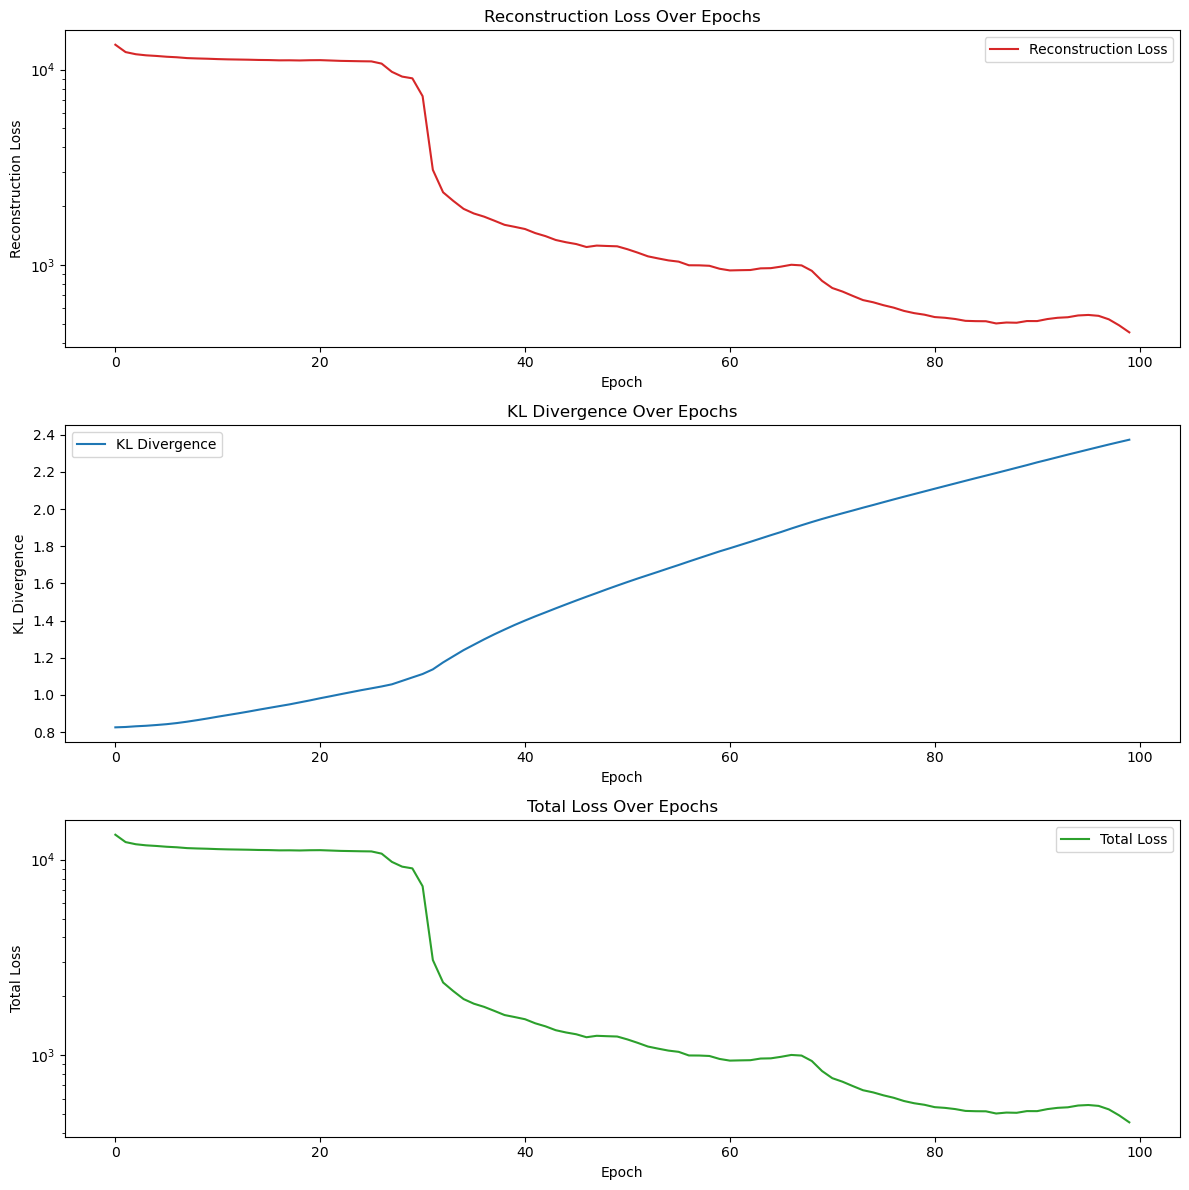

Training loss: 453.6254
Testing the VAD model...
Test loss: 0.1279


In [8]:
epochs = 100
beta = 1
learning_rate = 0.02
latent_dim = 60
model_normal = VariationalAutoDecoderNormal(latent_dim=latent_dim,lr=learning_rate)
train_loss,_,_ = model_normal.fit_and_train(num_epochs=epochs, beta=beta)
print(f'Training loss: {train_loss:.4f}')
test_loss = model_normal.test_vad(num_epochs=epochs, learning_rate=learning_rate)
print(f'Test loss: {test_loss:.4f}')

<p style="font-size:16px;">Plotting TSNE plot.</p>

In [9]:
file_name = 'tsne_plot_VAD_normal'
image_title = 'TSNE Plot VAD Normal Distribution'
model_normal.plot_tsne(file_name=file_name, plot_title=image_title)

Generating t-SNE plot...


<Figure size 800x600 with 0 Axes>

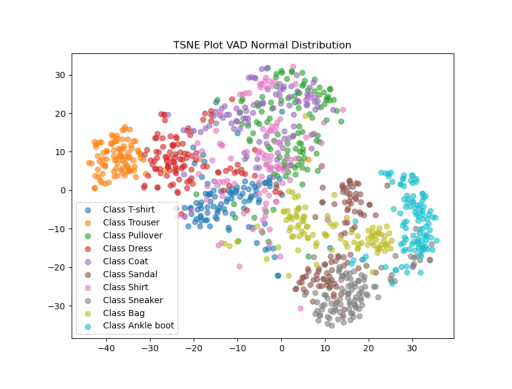

In [10]:
image_path = f'{file_name}.png'
img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

## Results Explanation
We can see that over all the classes are organized well.
From the plot we can observe that the different shoe classes are near each others, but the model learnt to distinguish between the different kind of shoes (sandals, sneakers, ankle boots).
The same explanation applies to the dress and trousers classes.
Besides that we can observe that the classes coat, pullover and and shirt are not seperated well in the latent space. This due to the fact that these classes have features that are difficult for the model to capture and differentuate between them.
Lastly we see that the bag class is very much apart from other classes but has two different clusters. This is probably due to the fact that are two kinds of bags.

#### Bags & Sandals Classes - different bags & Sandals

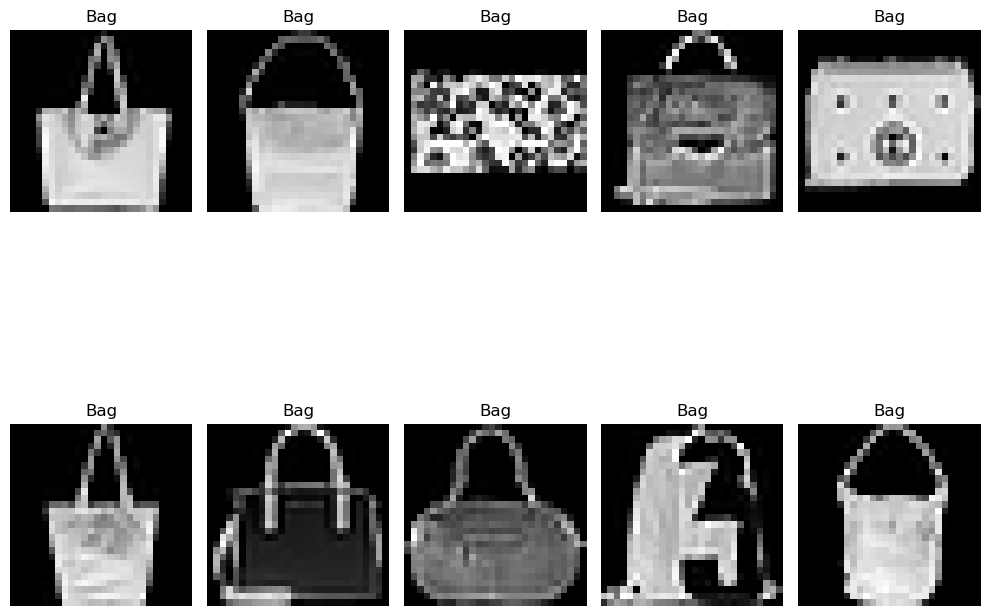

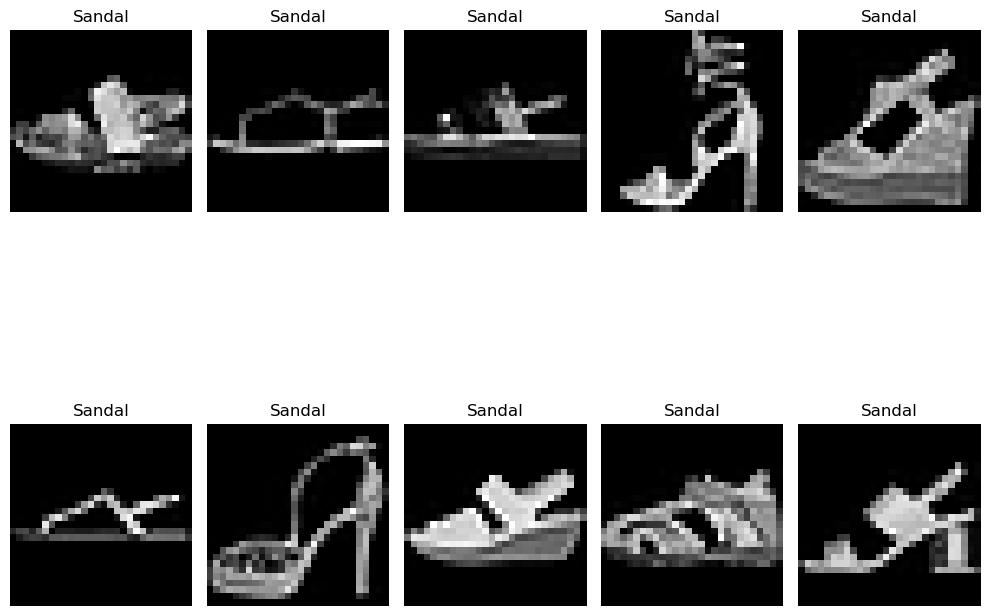

In [11]:
BAG_CLASS = 8
SANDALS_CLASS = 5
bag_images = [model_normal.train_ds.X[i] for i in range(len(model_normal.train_ds)) if model_normal.train_ds.y[i] == BAG_CLASS]
bag_images = bag_images[-5:] + bag_images[:5]

 
sandals_images = [model_normal.train_ds.X[i] for i in range(len(model_normal.train_ds)) if model_normal.train_ds.y[i] == SANDALS_CLASS]
sandals_images = sandals_images[-5:] + sandals_images[:5]

# Plot 10 bag images
plt.figure(figsize=(10, 10))
for i, img in enumerate(bag_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(img.numpy(), cmap="gray")
    plt.axis("off")
    plt.title("Bag")
plt.tight_layout()
plt.show()

# Plot 10 sandals images
plt.figure(figsize=(10, 10))
for i, img in enumerate(sandals_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(img.numpy(), cmap="gray")
    plt.axis("off")
    plt.title("Sandal")
plt.tight_layout()
plt.show()

We can see that there are two different types of bags - bags with a strap and amore enveloped type of bag.
In addition there are two different types of sandals - flat sandals and heeled sandals.

#### Shirt, Pullover & Coat Classes

In [12]:
PULLOVER_CLASS = 2
COAT_CLASS = 4
SHIRT_CLASS = 6

pullover_images = [model_normal.train_ds.X[i] for i in range(len(model_normal.train_ds)) if model_normal.train_ds.y[i] == PULLOVER_CLASS]
pullover_images = pullover_images[-5:] + pullover_images[:5]

coat_images = [model_normal.train_ds.X[i] for i in range(len(model_normal.train_ds)) if model_normal.train_ds.y[i] == COAT_CLASS]
coat_images = coat_images[-5:] + coat_images[:5]

shirt_images = [model_normal.train_ds.X[i] for i in range(len(model_normal.train_ds)) if model_normal.train_ds.y[i] == SHIRT_CLASS]
shirt_images = shirt_images[-5:] + shirt_images[:5]

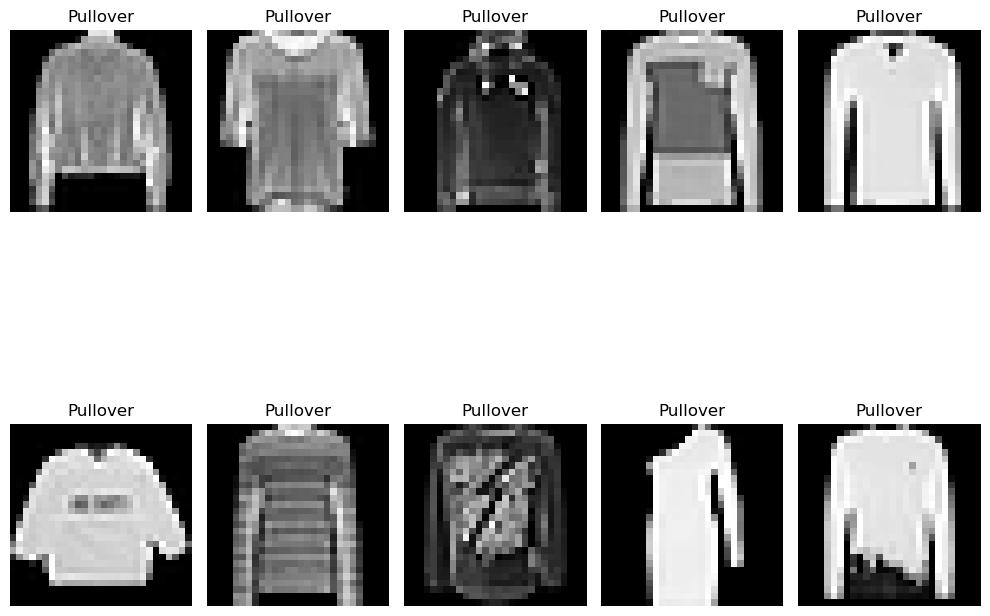

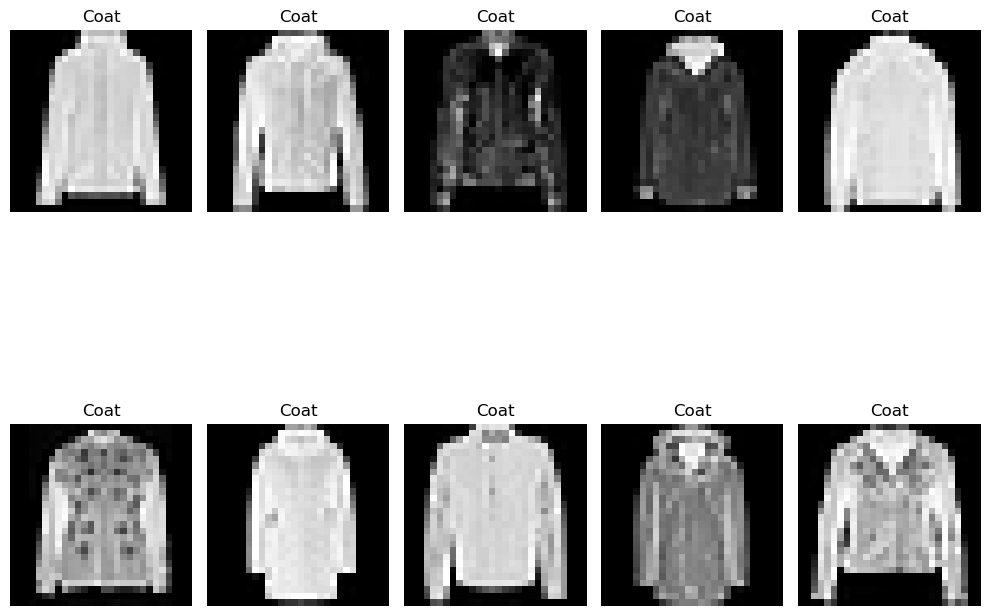

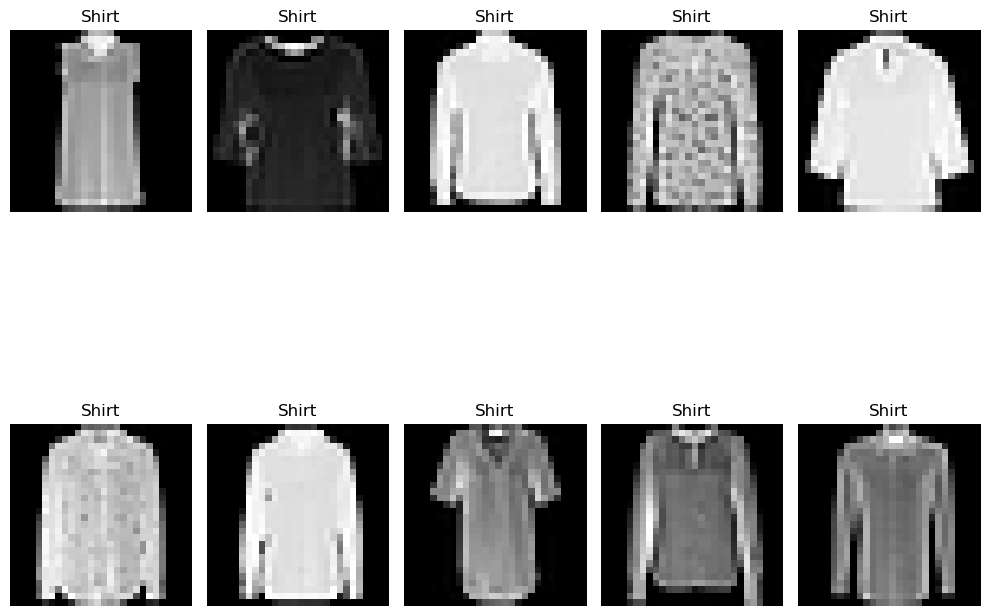

In [13]:
# Plot 10 pullover images
plt.figure(figsize=(10, 10))
for i, img in enumerate(pullover_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(img.numpy(), cmap="gray")
    plt.axis("off")
    plt.title("Pullover")
plt.tight_layout()
plt.show()

# Plot 10 coat images
plt.figure(figsize=(10, 10))
for i, img in enumerate(coat_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(img.numpy(), cmap="gray")
    plt.axis("off")
    plt.title("Coat")
plt.tight_layout()
plt.show()

# Plot 10 shirt images
plt.figure(figsize=(10, 10))
for i, img in enumerate(shirt_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(img.numpy(), cmap="gray")
    plt.axis("off")
    plt.title("Shirt")
plt.tight_layout()
plt.show()

As we can see from the images above, it is very hard to tell the difference between the three classes.

### Testing Samples

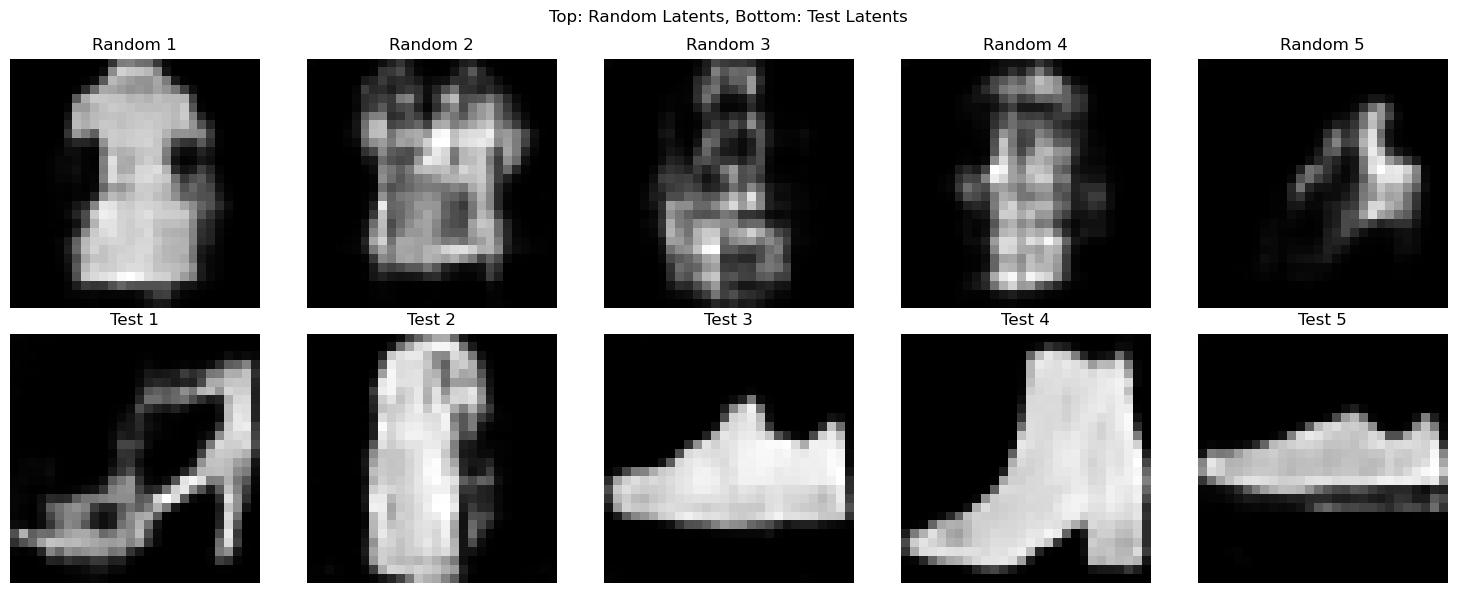

In [98]:
random_latents = torch.randn(5, model_normal.latent_dim).to(model_normal.device)  # Sample from standard normal
random_decoded = model_normal.decode(random_latents)  # Decode the sampled latents

test_indices = torch.randint(0, len(model_normal.test_ds), (5,))
test_parameters = model_normal.test_parameters[test_indices]

test_mu = test_parameters[:, :model_normal.latent_dim]
test_log_var = test_parameters[:, model_normal.latent_dim:]

test_latents = model_normal._reparameterize(test_mu, test_log_var)
test_decoded = model_normal.decode(test_latents)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, (random_img, test_img) in enumerate(zip(random_decoded, test_decoded)):
    axes[0, i].imshow(random_img.cpu().detach().numpy(), cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title(f"Random {i + 1}")

    axes[1, i].imshow(test_img.cpu().detach().numpy(), cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title(f"Test {i + 1}")

plt.suptitle("Top: Random Latents, Bottom: Test Latents")
plt.tight_layout()
plt.show()

### Explanation

The images reconstructed from test latents are generally better because:
1. Test latent vectors are optimized during inference to minimize the reconstruction loss,ensuring that the latent representations capture meaningful features of the input data. This means they're found in regions of the latent space that the decoder has learned to map to realistic images during training.
2. While we train the VAD to push the latent distributions towards N(0, I), the actual learned distribution might not perfectly match this target distribution. There might be specific regions within the N(0, I) space that the model learns to associate with realistic images, while other regions might map to less realistic outputs. Random latents sampled from N(0, I) are not specific to the data distribution and may lie in regions of latent space that are less meaningful or poorly supported by the decoder. This highlights how the latent space learned by the model is data-dependent and structured to capture patterns in the training data.

### Interpolating Samples
It was unclear from the task how many interpolated samples we need to present - that task stated five, but also refered to an example with 10 images with 8 interpolations (original images in the start and the end).

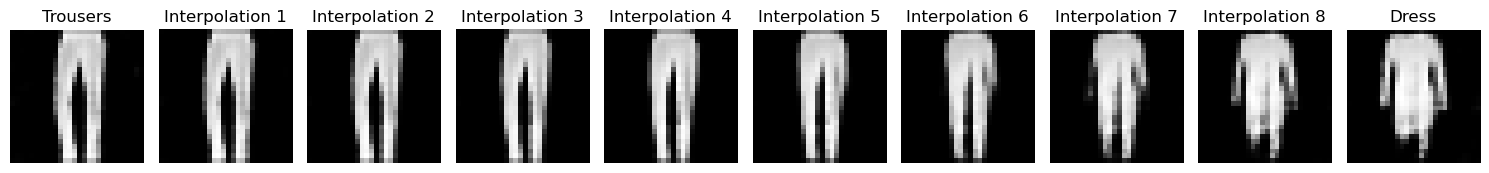

In [99]:
TROUSERS_CLASS = 1
DRESS_CLASS = 3

trousers_images = [i for i in range(len(model_normal.test_ds)) if model_normal.test_ds.y[i] == TROUSERS_CLASS]
dress_images = [i for i in range(len(model_normal.test_ds)) if model_normal.test_ds.y[i] == DRESS_CLASS]
 
trousers_index = trousers_images[0]
dress_index = dress_images[0]

trousers_params = model_normal.test_parameters[trousers_index]
dress_params = model_normal.test_parameters[dress_index]

trousers_mu = trousers_params[:model_normal.latent_dim]
trousers_log_var = trousers_params[model_normal.latent_dim:]

dress_mu = dress_params[:model_normal.latent_dim]
dress_log_var = dress_params[model_normal.latent_dim:]

latent_trousers = model_normal._reparameterize(trousers_mu, trousers_log_var)
latent_dress = model_normal._reparameterize(dress_mu, dress_log_var)




interpolation_coeffs = torch.linspace(0.1, 0.9, steps=9)

# Step 2: Interpolate between latent_bag and latent_sandal
interpolated_latents = [
    (1 - t) * latent_trousers + t * latent_dress for t in interpolation_coeffs
]

# Step 3: Decode the original and interpolated latent vectors
decoded_images = [model_normal.decode(latent.unsqueeze(0)).squeeze(0) for latent in [latent_trousers, *interpolated_latents, latent_dress]]

# Step 4: Plot the images
fig, axes = plt.subplots(1, len(decoded_images)-1, figsize=(15, 3))
titles = ['Trousers', 'Interpolation 1', 'Interpolation 2', 'Interpolation 3', 'Interpolation 4', 'Interpolation 5', 'Interpolation 6', 'Interpolation 7', 'Interpolation 8','Dress']

for ax, image, title in zip(axes, decoded_images, titles):
    ax.imshow(image.cpu().detach().numpy(), cmap='gray')
    ax.axis('off')
    ax.set_title(title)

plt.tight_layout()
plt.show()

### Using Different Distributions
#### Laplace Distibution

We decided to use the laplace distribution.
The laplace distribution is known for producing sparse representations due to its sharper peak around the mean. Sparse representations allow the latent space to focus on the most important features of the data. Moreover, the laplace distribution has a sharp peak around the mean, and the probability for extreme values decreases more slowly than it does for the normal distribution. This is why the distribution's extreme values are still relatively more likely. In data that contains rare but significant features, the laplace distribution can represent such variability. This can help distinguish between similar classes. In addition, it can potentially improve the model’s ability to generate realistic and varied samples.

**Modifying The Reparametrization Trick**

The trick transforms a sample from $ \text{Uniform}(0, 1) $ into a sample from $ \text{Laplace}(\mu, b)$.

**1. Laplace Distribution Properties**
- **PDF**:  
  $$
  f(x) = \frac{1}{2b} \exp\left(-\frac{|x - \mu|}{b}\right)
  $$

- **CDF**:  
  $$
  F(x) =
  \begin{cases}
  \frac{1}{2} \exp\left(\frac{x - \mu}{b}\right) & \text{if } x \leq \mu, \\
  1 - \frac{1}{2} \exp\left(-\frac{x - \mu}{b}\right) & \text{if } x > \mu.
  \end{cases}
  $$

**2. Using Cases**
The Laplace CDF is piecewise-defined:
- For $ x \leq \mu $, the CDF grows exponentially toward \( 0.5 \).
- For $ x > \mu $, the CDF grows exponentially from \( 0.5 \) to \( 1 \).

This requires splitting the inverse CDF into two cases:
- $ u \leq 0.5 $: Corresponds to the left half of the Laplace distribution.
- $ u > 0.5 $: Corresponds to the right half.


**Deriving the Inverse CDF**
To reparameterize, we solve \( u = F(x) \) for \( x \):

- For $ u \leq 0.5 $:  
  $$ u = \frac{1}{2} \exp\left(\frac{x - \mu}{b}\right) \implies x = \mu + b \log(2u). $$

- For $ u > 0.5 $:  
  $$ u = 1 - \frac{1}{2} \exp\left(-\frac{x - \mu}{b}\right) \implies x = \mu - b \log(2 - 2u). $$


**4. Final Reparameterization Formula**
To sample $ z \sim \text{Laplace}(\mu, b) $:

$$
z = \mu + b \cdot F^{-1}(u),
$$

where $ F^{-1}(u) $ is the inverse CDF:

- If $ u \leq 0.5 $:  
  $$
  z = \mu + b \cdot \log(2u).
  $$

- If $ u > 0.5 $:
  $$
  z = \mu - b \cdot \log(2 - 2u).
  $$

**KL Divergence**

The KL divergence between a posterior Laplace distribution $ q(z) $ and a prior Laplace distribution $ p(z) $ is:

- Posterior: $ q(z) \sim \text{Laplace}(0, 1) $
  $$
  q(z) = \frac{1}{2} \exp(-|z|)
  $$
- Prior: $ p(z) \sim \text{Laplace}(\mu_p, b_p) $
  $$
  p(z) = \frac{1}{2b_p} \exp \left( -\frac{|z - \mu_p|}{b_p} \right)
  $$

The formula for KL divergence is:

$$
D_{KL}(q(z) \, || \, p(z)) = \mathbb{E}_{z \sim q(z)} \left[ \log \frac{q(z)}{p(z)} \right]
$$

**Step 1: Substitute the formulas for $ q(z) $ and $ p(z) $**

$$
\log \frac{q(z)}{p(z)} = \log \left( \frac{\frac{1}{2} \exp(-|z|)}{\frac{1}{2b_p} \exp\left(-\frac{|z - \mu_p|}{b_p}\right)} \right)
$$

Simplifying:

$$
= \log \left( \frac{b_p}{1} \right) - \left( |z| - \frac{|z - \mu_p|}{b_p} \right)
$$

**Step 2: Compute the expectation**

$$
D_{KL}(q(z) \, || \, p(z)) = \mathbb{E}_{z \sim q(z)} \left[ \log(b_p) - |z| + \frac{|z - \mu_p|}{b_p} \right]
$$

Breaking it into terms:

1. $ \mathbb{E}_{z \sim q(z)} \left[ \log(b_p) \right] = \log(b_p) $
2. $ \mathbb{E}_{z \sim q(z)} \left[ |z| \right] = 1 $ (since $ b_q = 1 $)
3. $ \mathbb{E}_{z \sim q(z)} \left[ |z - \mu_p| \right] = 1 + |\mu_p| $

**Final Expression:**

$$
D_{KL}(q(z) \, || \, p(z)) = \log(b_p) - 1 + \frac{1 + |\mu_p|}{b_p}
$$


#### Training VAD with Laplace Distribution

Training the VAD model...
Epoch 1, Loss: 13743.8640
Epoch 2, Loss: 13134.5948
Epoch 3, Loss: 13134.4305
Epoch 4, Loss: 13134.2817
Epoch 5, Loss: 13134.1601
Epoch 6, Loss: 13134.0676
Epoch 7, Loss: 13133.9484
Epoch 8, Loss: 13133.9030
Epoch 9, Loss: 13133.8365
Epoch 10, Loss: 13133.7779
Epoch 11, Loss: 13133.7101
Epoch 12, Loss: 13133.6739
Epoch 13, Loss: 13133.6288
Epoch 14, Loss: 13133.5950
Epoch 15, Loss: 13133.5382
Epoch 16, Loss: 13133.4032
Epoch 17, Loss: 13133.5184
Epoch 18, Loss: 13133.3806
Epoch 19, Loss: 13133.4402
Epoch 20, Loss: 13133.4518
Epoch 21, Loss: 13133.2715
Epoch 22, Loss: 13132.9129
Epoch 23, Loss: 13133.2447
Epoch 24, Loss: 13133.2500
Epoch 25, Loss: 13132.8489
Epoch 26, Loss: 13131.6227
Epoch 27, Loss: 13125.5274
Epoch 28, Loss: 12529.9809
Epoch 29, Loss: 10844.6006
Epoch 30, Loss: 8561.9750
Epoch 31, Loss: 7436.5455
Epoch 32, Loss: 6826.2465
Epoch 33, Loss: 6075.0935
Epoch 34, Loss: 5482.9710
Epoch 35, Loss: 5090.4682
Epoch 36, Loss: 4821.6385
Epoch 37, Loss: 47

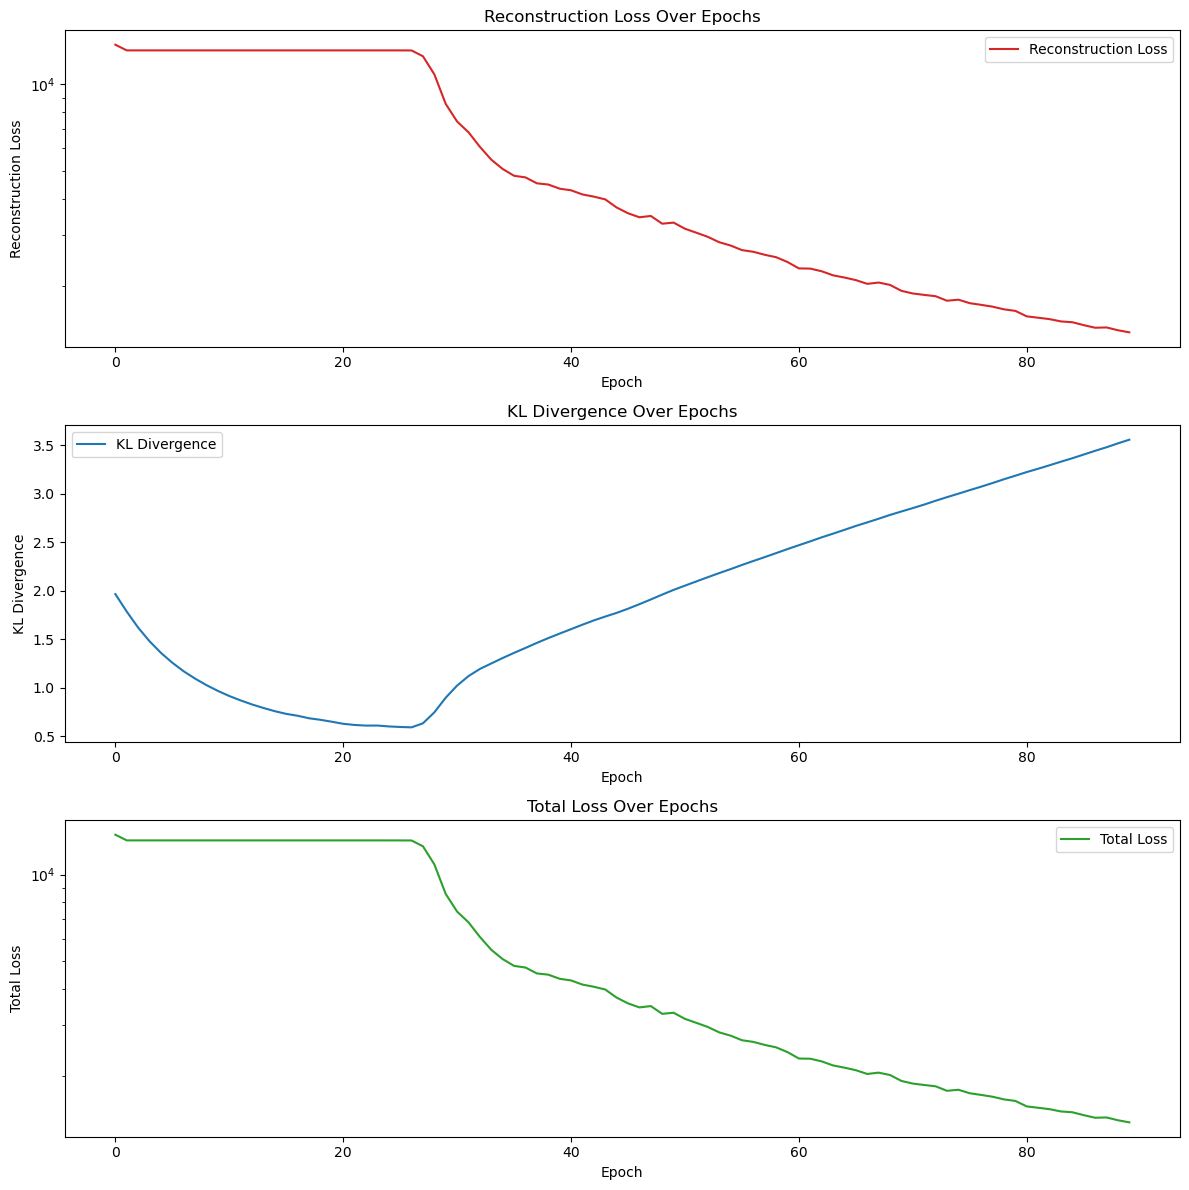

Training loss: 1382.7998
Testing the VAD model...
Test loss: 0.1538


In [2]:
epochs = 90
beta = 1
learning_rate = 0.02
latent_dim = 60
model_laplace = VariationalAutoDecoderLaplace(latent_dim=latent_dim,lr=learning_rate)
train_loss,_,_ = model_laplace.fit_and_train(num_epochs=epochs, beta=beta)
print(f'Training loss: {train_loss:.4f}')
test_loss = model_laplace.test_vad(num_epochs=epochs, learning_rate=learning_rate)
print(f'Test loss: {test_loss:.4f}')

In [47]:
file_name = 'tsne_plot_VAD_laplace'
image_title = 'TSNE Plot VAD Laplace Distribution'
model_laplace.plot_tsne(file_name=file_name, plot_title=image_title)

Generating t-SNE plot...


<Figure size 800x600 with 0 Axes>

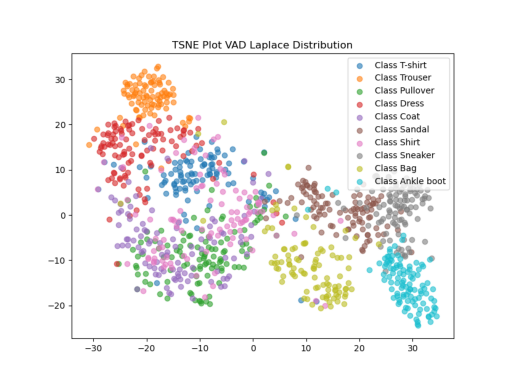

In [48]:
image_path = f'{file_name}.png'
img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

## Results Explanation
We can observe that the dress class is more scattered rather than in the previous plot. This is probably due to characteristics of the laplace distribution - able to represent rare features in the data. So, the model learnt to distinguish well between the different dresses - with and without sleeve (see below).
The pullover class is more concetrated than in the previous plot, suggesting that the model learnt its features better.

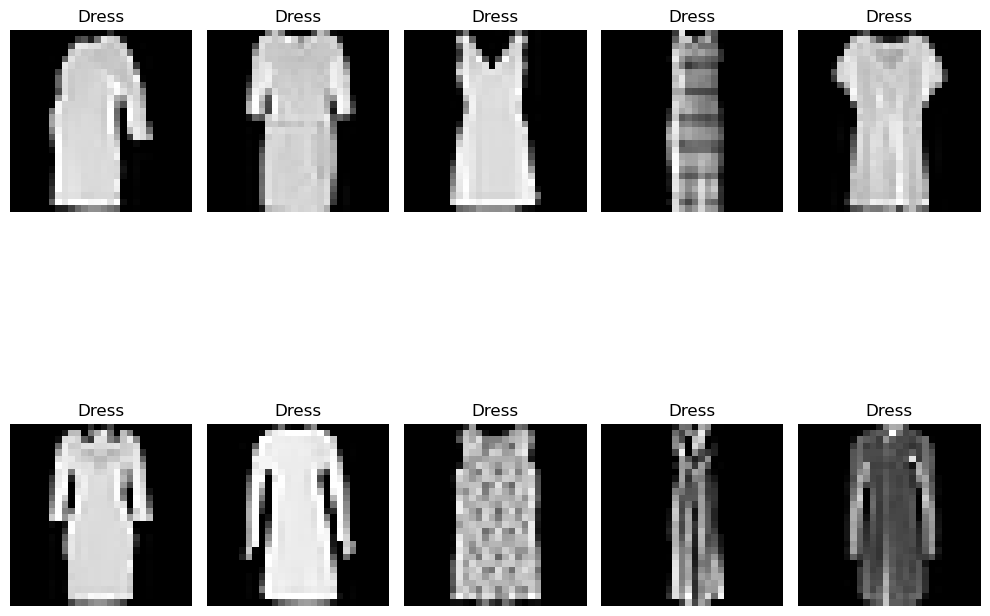

In [52]:
DRESS_CLASS = 3

dress_images = [model_laplace.train_ds.X[i] for i in range(len(model_laplace.train_ds)) if model_laplace.train_ds.y[i] == DRESS_CLASS]
dress_images = dress_images[-5:] + dress_images[:5]

# Plot 10 dress images
plt.figure(figsize=(10, 10))
for i, img in enumerate(dress_images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(img.numpy(), cmap="gray")
    plt.axis("off")
    plt.title("Dress")
plt.tight_layout()
plt.show()

We can see that there are dresses without sleeves and some are with. The model probably learnt this difference in the between the kind of dresses.

### Testing Samples

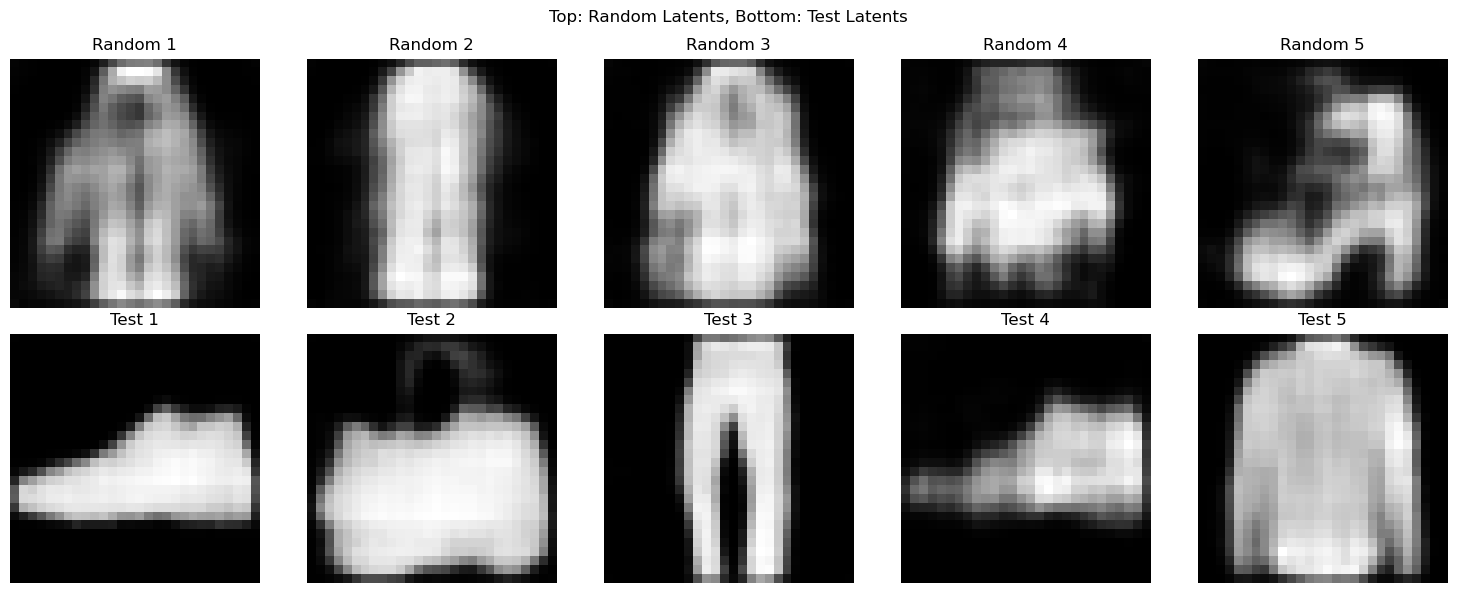

In [29]:
laplace_dist = torch.distributions.Laplace(0,1)
random_latents = laplace_dist.sample((5, model_laplace.latent_dim)).to(model_laplace.device) # Sample from Laplace(0,1)
random_decoded = model_laplace.decode(random_latents)  # Decode the sampled latents

test_indices = torch.randint(0, len(model_laplace.test_ds), (5,))
test_parameters = model_laplace.test_parameters[test_indices]

test_mu = test_parameters[:, :model_laplace.latent_dim]
test_log_b = test_parameters[:, model_laplace.latent_dim:]

test_latents = model_laplace._reparameterize(test_mu, test_log_b)
test_decoded = model_laplace.decode(test_latents)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, (random_img, test_img) in enumerate(zip(random_decoded, test_decoded)):
    axes[0, i].imshow(random_img.cpu().detach().numpy(), cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title(f"Random {i + 1}")

    axes[1, i].imshow(test_img.cpu().detach().numpy(), cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title(f"Test {i + 1}")

plt.suptitle("Top: Random Latents, Bottom: Test Latents")
plt.tight_layout()
plt.show()

#### What's Happening in the Images

**Top Row (Random Latents)**
These images are generated by sampling random values from a $ \text{Laplace}(0, 1) $ distribution and passing them through the model's decoder. Since the model was trained to make its latent space follow this distribution, we expect the outputs to resemble items from the dataset.

The images do look somewhat like pieces of clothing, but they’re blurrier and lack detail. This suggests that while the model has learned the general structure of the dataset, it struggles to fully capture fine details when generating from purely random latent points.

**Bottom Row (Test Latents)**
These images come from latent vectors directly tied to test data. The model predicts specific parameters (mean and scale) for each test sample, and these parameters are used to generate the latent vectors.

Since these latents are "informed" by real data, the decoder produces clearer and sharper images that closely resemble the original dataset. This shows that the model is effective at reconstructing real examples from the test set.

**What This Comparison Shows**
- The random latent images (top row) show how well the model can generate new, unseen examples based only on the prior distribution it was trained on. While the outputs are plausible, the blurriness suggests the model struggles to generate highly detailed images from purely random inputs.
- The test latent images (bottom row) highlight how well the model can recreate data it has seen during training. These images are much clearer and more detailed, indicating that the model has learned to represent the dataset effectively in its latent space.

### Interpolating Samples

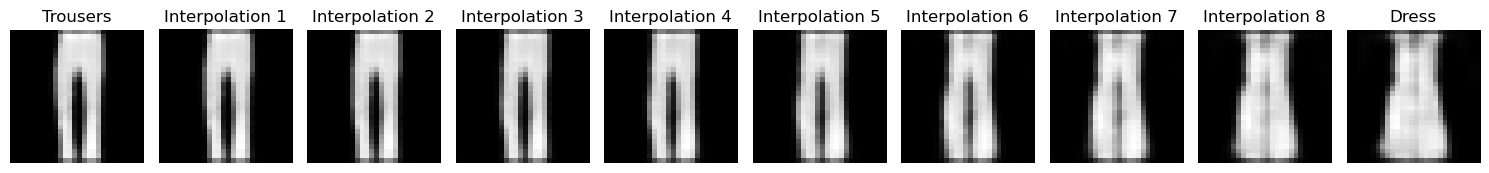

In [37]:
TROUSERS_CLASS = 1
DRESS_CLASS = 3

trousers_images = [i for i in range(len(model_laplace.test_ds)) if model_laplace.test_ds.y[i] == TROUSERS_CLASS]
dress_images = [i for i in range(len(model_laplace.test_ds)) if model_laplace.test_ds.y[i] == DRESS_CLASS]
 
trousers_index = trousers_images[0]
dress_index = dress_images[-4]

trousers_params = model_laplace.test_parameters[trousers_index]
dress_params = model_laplace.test_parameters[dress_index]

trousers_mu = trousers_params[:model_laplace.latent_dim]
trousers_log_b = trousers_params[model_laplace.latent_dim:]

dress_mu = dress_params[:model_laplace.latent_dim]
dress_log_b = dress_params[model_laplace.latent_dim:]

latent_trousers = model_laplace._reparameterize(trousers_mu, trousers_log_b)
latent_dress = model_laplace._reparameterize(dress_mu, dress_log_b)




interpolation_coeffs = torch.linspace(0.1, 0.9, steps=9)

interpolated_latents = [
    (1 - t) * latent_trousers + t * latent_dress for t in interpolation_coeffs
]

decoded_images = [model_laplace.decode(latent.unsqueeze(0)).squeeze(0) for latent in [latent_trousers, *interpolated_latents, latent_dress]]

fig, axes = plt.subplots(1, len(decoded_images)-1, figsize=(15, 3))
titles = ['Trousers', 'Interpolation 1', 'Interpolation 2', 'Interpolation 3', 'Interpolation 4', 'Interpolation 5', 'Interpolation 6', 'Interpolation 7', 'Interpolation 8','Dress']

for ax, image, title in zip(axes, decoded_images, titles):
    ax.imshow(image.cpu().detach().numpy(), cmap='gray')
    ax.axis('off')
    ax.set_title(title)

plt.tight_layout()
plt.show()

### Exponential Distribution

We chose the exponential distribution because it has similar characteristics to the Laplace distribution - Sparse and heavy tail.
The probability density peaks near $0$ and decreases rapidly. That means the exponential distribution tends to produce values close to $0$ with usually larger values. As a result, most latent dimensions remain inactive (close to zero), and only a few become active.
Moreover, regarding the heavy tail - the exponential decay still allows large values, this helps balance sparsity and the ability to capture significant deviations. In addition, the exponential distribution is strictly defined for positive real numbers. This makes it particularly suited for exploring how non-Gaussian, positive-only latent representations influence model behavior.

**Modifying the Reparameterization Trick**:  
The reparameterization trick for the exponential distribution transform a sample from a uniform distribution $ \text{Uniform}(0, 1) $ into a sample from $ \text{Exponential}(\lambda)$ using the inverse cumulative distribution function (CDF).

**1. Exponential Distribution Properties**

- **PDF**:
$$
f(x; \lambda) = \lambda e^{-\lambda x}, \quad x \geq 0
$$

- **CDF**:
$$
F(x; \lambda) = 1 - e^{-\lambda x}, \quad x \geq 0
$$

**2. Deriving the Inverse CDF and the Final Reparameterization Formula**

The reparameterization involves solving $u = F(x; \lambda)$ for $x$, where $u \sim U(0,1)$ Substituting the exponential CDF:
$$
u = 1 - e^{-\lambda x} \implies e^{-\lambda x} = 1 - u \implies x = -\frac{\ln(1 - u)}{\lambda}
$$

Here, $u \sim U(0, 1)$, so $1 - u$ is also uniform, ensuring consistent sampling. To avoid numerical issues with $ \ln(0) $, $u$ is clamped between $(0 + \epsilon, 1 - \epsilon)$, where $\epsilon$ is a small constant.

To sample $ z \sim \text{Exponential}(\lambda) $, we use the formula:
$$
z = -\frac{1}{\lambda}\ln(\epsilon), \quad \epsilon \sim U(0, 1)
$$


**KL Divergence**


The KL divergence measures the difference between the posterior 
$q(z) \sim \text{Exponential}(\lambda_q)$ and the prior $p(z) \sim \text{Exponential}(\lambda_p)$
The formula for KL divergence is:
$$
D_{KL}(q(z) \, || \, p(z)) = \mathbb{E}_{z \sim q(z)} \left[ \log \frac{q(z)}{p(z)} \right]
$$

**Step 1: Substitute the PDFs**

The PDFs for the posterior and prior are:
- $q(z)=\lambda_q e^{-\lambda_q z}$
- $p(z)=\lambda_p e^{-\lambda_p z}$
 
The log ratio is:

$$
\log \frac{q(z)}{p(z)} = \log \left(\frac{\lambda_q e^{-\lambda_q z}}{\lambda_p e^{-\lambda_p z}}\right) = \log \left(\frac{\lambda_q}{\lambda_p}\right) + (\lambda_p - \lambda_q)z.
$$


**Step 2: Compute the Expectation**

The expectation is taken over $z \sim q(z)$, whose mean is $\mathbb{E}_{z \sim q(z)}[z] = \frac{1}{\lambda_q}$:


$$
D_{KL}(q(z) \,||\, p(z)) = \log \left(\frac{\lambda_q}{\lambda_p}\right) + \lambda_p \mathbb{E}[z] - 1 = \log \left(\frac{\lambda_q}{\lambda_p}\right) + \frac{\lambda_p}{\lambda_q} - 1.
$$
Breaking this into terms:

- $\mathbb{E}[z]\log \left(\frac{\lambda_q}{\lambda_p}\right)=\log \left(\frac{\lambda_q}{\lambda_p}\right)$
- $(\lambda_p-\lambda_q)\mathbb{E}_{z \sim q(z)}[z] = (\lambda_p-\lambda_q)\frac{1}{\lambda_q}$

**Final Expression:**
$$
D_{KL}(q(z) \,||\, p(z)) = \log \left(\frac{\lambda_q}{\lambda_p}\right) + \lambda_p \mathbb{E}[z] - 1 = \log \left(\frac{\lambda_q}{\lambda_p}\right) + \frac{\lambda_p-\lambda_q}{\lambda_q}.
$$
 
This is minimized when $\lambda_q = \lambda_p$, reflecting minimal divergence between the prior and posterior. The divergence increases as the two distributions become more dissimilar.


#### Training VAD with Exponential Distribution

Training the VAD model...
Epoch 1, Loss: 13411.9787
Epoch 2, Loss: 12476.5875
Epoch 3, Loss: 11470.8912
Epoch 4, Loss: 8449.1745
Epoch 5, Loss: 6233.2014
Epoch 6, Loss: 5374.5296
Epoch 7, Loss: 5096.2209
Epoch 8, Loss: 4834.8177
Epoch 9, Loss: 4650.3209
Epoch 10, Loss: 4541.3203
Epoch 11, Loss: 4304.9546
Epoch 12, Loss: 4129.5786
Epoch 13, Loss: 3964.6228
Epoch 14, Loss: 3777.5795
Epoch 15, Loss: 3665.2741
Epoch 16, Loss: 3552.9413
Epoch 17, Loss: 3470.6985
Epoch 18, Loss: 3395.8602
Epoch 19, Loss: 3262.2724
Epoch 20, Loss: 3187.2619
Epoch 21, Loss: 3129.8760
Epoch 22, Loss: 3042.2386
Epoch 23, Loss: 2945.3713
Epoch 24, Loss: 2891.9413
Epoch 25, Loss: 2768.2652
Epoch 26, Loss: 2753.3766
Epoch 27, Loss: 2694.1624
Epoch 28, Loss: 2618.8780
Epoch 29, Loss: 2587.8409
Epoch 30, Loss: 2558.6253
Epoch 31, Loss: 2498.9043
Epoch 32, Loss: 2426.4816
Epoch 33, Loss: 2430.5914
Epoch 34, Loss: 2395.5582
Epoch 35, Loss: 2331.2984
Epoch 36, Loss: 2259.8536
Epoch 37, Loss: 2290.4155
Epoch 38, Loss: 22

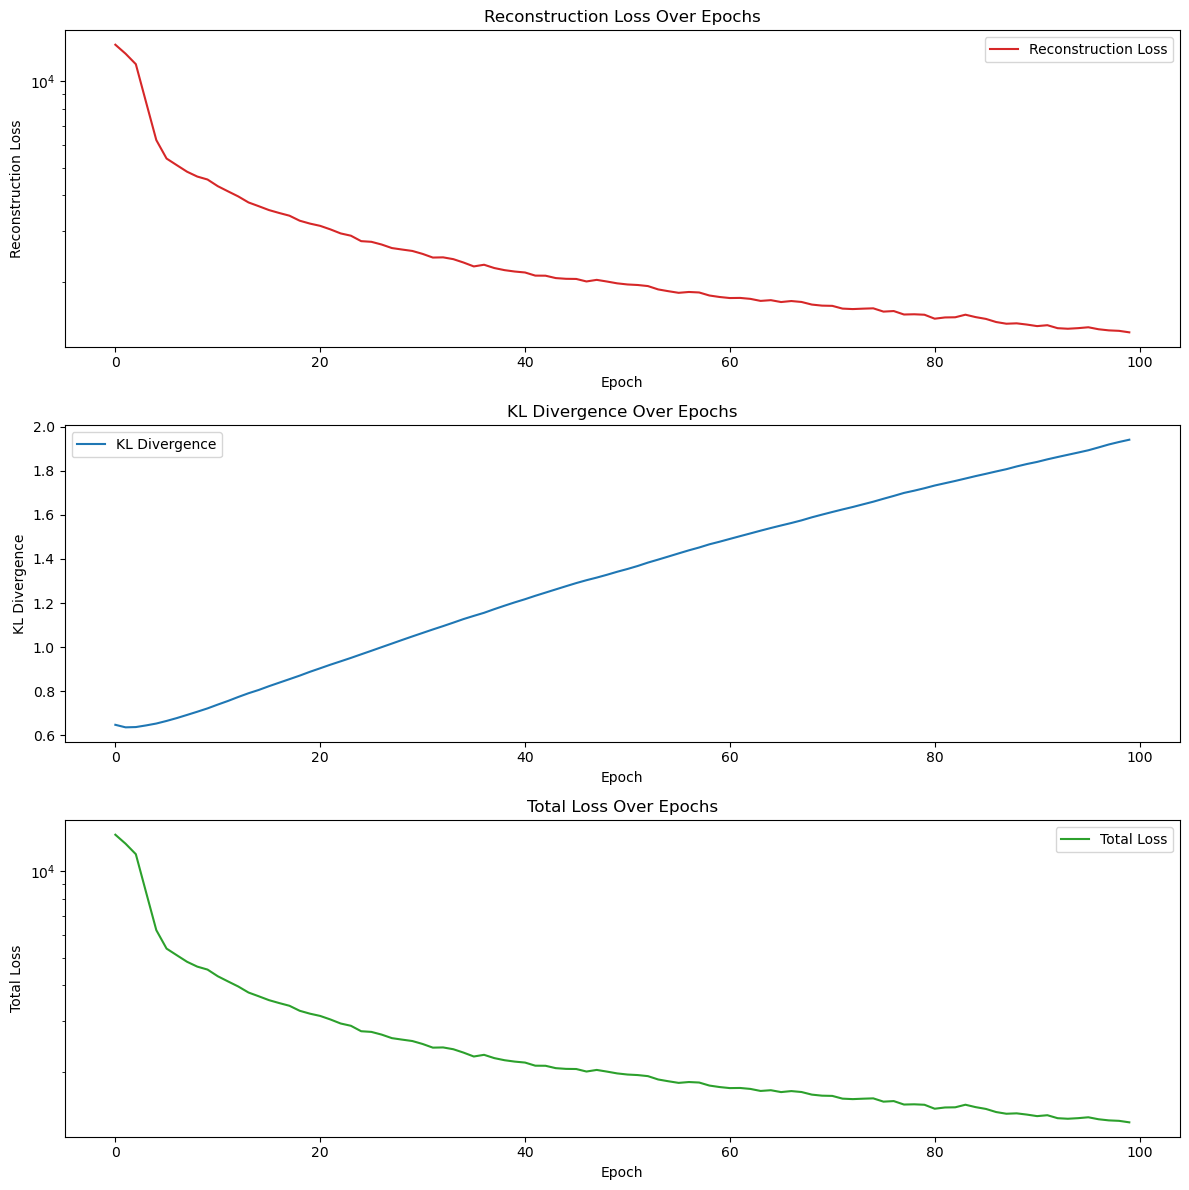

Training loss: 1331.9361
Testing the VAD model...
Test loss: 0.1758


In [2]:
epochs = 100
beta = 1
learning_rate = 0.015
latent_dim = 60
model_exp = VariationalAutoDecoderExponential(latent_dim=latent_dim,lr=learning_rate)
train_loss,_,_ = model_exp.fit_and_train(num_epochs=epochs, beta=beta)
print(f'Training loss: {train_loss:.4f}')
test_loss = model_exp.test_vad(num_epochs=epochs, learning_rate=learning_rate)
print(f'Test loss: {test_loss:.4f}')

In [3]:
file_name = 'tsne_plot_VAD_exp'
image_title = 'TSNE Plot VAD Exponential Distribution'
model_exp.plot_tsne(file_name=file_name, plot_title=image_title)

Generating t-SNE plot...


<Figure size 800x600 with 0 Axes>

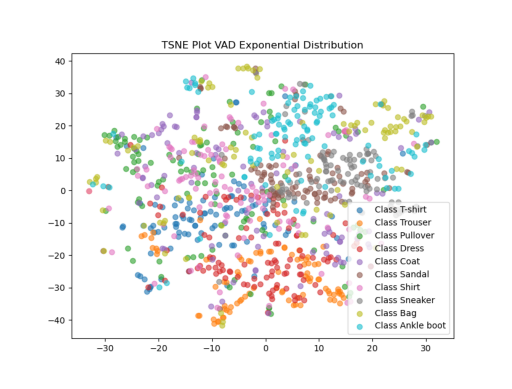

In [4]:
image_path = f'{file_name}.png'
img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

## Results Explanation
We can see that most of the classes are mixed inside the picture and only a few classes are almost separate so we can think about them as clusters. This happens because the exponential distribution is probably not a good prior decision for this dataset, which means it is difficult for the model to organize the latent space effectively when using this distribution.

### Testing Samples

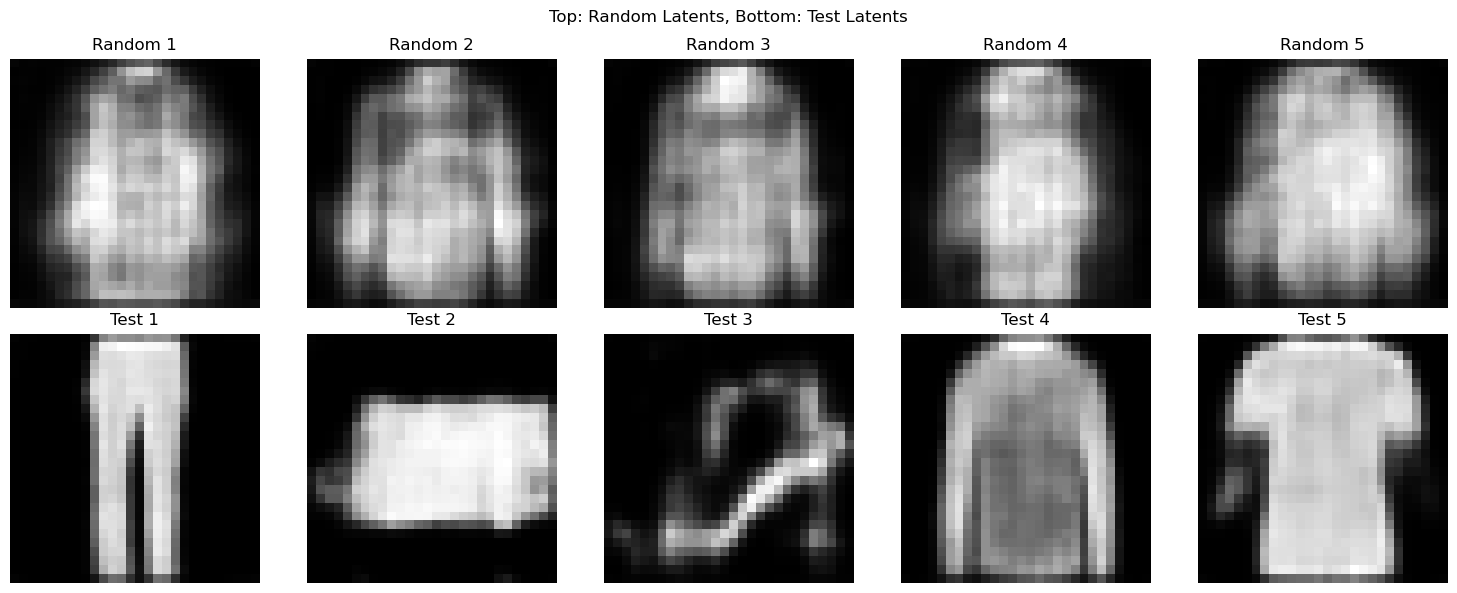

In [12]:
exponential_dist = torch.distributions.exponential.Exponential(1.0) 

random_latents = exponential_dist.sample((5, model_exp.latent_dim)).to(model_exp.device) # Sample from Exponential(1)
random_decoded = model_exp.decode(random_latents)  # Decode the sampled latents

test_indices = torch.randint(0, len(model_exp.test_ds), (5,))
test_log_lambda = model_exp.test_log_lambda[test_indices]


test_latents = model_exp._reparameterize(test_log_lambda)
test_decoded = model_exp.decode(test_latents)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, (random_img, test_img) in enumerate(zip(random_decoded, test_decoded)):
    axes[0, i].imshow(random_img.cpu().detach().numpy(), cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title(f"Random {i + 1}")

    axes[1, i].imshow(test_img.cpu().detach().numpy(), cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title(f"Test {i + 1}")

plt.suptitle("Top: Random Latents, Bottom: Test Latents")
plt.tight_layout()
plt.show()

### What's Happening in the Images

When decoding latent vectors into images, the quality of the decoded results heavily depends on how well the latent space aligns with the data distribution.

**Exponential Random Samples (Top Row)**: These fail to produce meaningful images because the Exponential distribution is a poor prior for this dataset. It skews the sampling process, leading to latent vectors that fall outside the meaningful regions of the latent space, where the decoder cannot map them to valid outputs.

**Test Set Latents (Bottom Row)**: These are better aligned with the latent space, as they originate from the same distribution as the training data. Decoding these latents results in high-quality images because the decoder was explicitly trained to reconstruct data from these regions of the latent space.

### Interpolating Samples

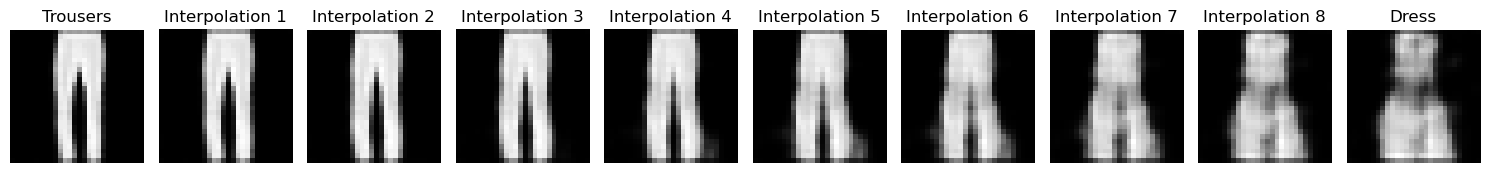

In [13]:
TROUSERS_CLASS = 1
DRESS_CLASS = 3

trousers_images = [i for i in range(len(model_exp.test_ds)) if model_exp.test_ds.y[i] == TROUSERS_CLASS]
dress_images = [i for i in range(len(model_exp.test_ds)) if model_exp.test_ds.y[i] == DRESS_CLASS]
 
trousers_index = trousers_images[0]
dress_index = dress_images[-4]

trousers_test_log_lambda = model_exp.test_log_lambda[trousers_index]
dress_test_log_lambda = model_exp.test_log_lambda[dress_index]


latent_trousers = model_exp._reparameterize(trousers_test_log_lambda)
latent_dress = model_exp._reparameterize(dress_test_log_lambda)




interpolation_coeffs = torch.linspace(0.1, 0.9, steps=9)

interpolated_latents = [
    (1 - t) * latent_trousers + t * latent_dress for t in interpolation_coeffs
]

decoded_images = [model_exp.decode(latent.unsqueeze(0)).squeeze(0) for latent in [latent_trousers, *interpolated_latents, latent_dress]]

fig, axes = plt.subplots(1, len(decoded_images)-1, figsize=(15, 3))
titles = ['Trousers', 'Interpolation 1', 'Interpolation 2', 'Interpolation 3', 'Interpolation 4', 'Interpolation 5', 'Interpolation 6', 'Interpolation 7', 'Interpolation 8','Dress']

for ax, image, title in zip(axes, decoded_images, titles):
    ax.imshow(image.cpu().detach().numpy(), cmap='gray')
    ax.axis('off')
    ax.set_title(title)

plt.tight_layout()
plt.show()